## CIFファイルの情報から原子座標を生成する

In [1]:
from genice2.cell import cellvectors
from genice2 import CIF

a = 8.508 / 10.0  # nm
A = 89.32

# cellvectors関数は単位胞の幾何形状情報を行列にする。
cell = cellvectors(a, a, a, A, A, A)
cell

array([[0.8508    , 0.        , 0.        ],
       [0.01009726, 0.85074008, 0.        ],
       [0.01009726, 0.00997813, 0.85068156]])

In [3]:
import numpy as np

atoms = """   C1         1.0     0.575000      0.575000      0.575000     Biso  1.000000 C
   C2         1.0     0.953000      0.953000      0.953000     Biso  1.000000 C
   C3         1.0     0.186000      0.186000      0.186000     Biso  1.000000 C
   C4         1.0     0.833000      0.291000      0.701000     Biso  1.000000 C
   C5         1.0     0.455000      0.318000      0.839000     Biso  1.000000 C
   C6         1.0     0.720000      0.626000      0.953000     Biso  1.000000 C
   C7         1.0     0.519000      0.189000      0.435000     Biso  1.000000 C
   C8         1.0     0.938000      0.072000      0.420000     Biso  1.000000 C
   C9         1.0     0.204000      0.085000      0.703000     Biso  1.00
""".splitlines()

# pick up 3 columns
atoms = [line.split()[2:5] for line in atoms]

# and make them floats
atoms = np.array(atoms).astype(float)

# make them a dict
atomd = { f"C{i}": x for i, x in enumerate(atoms) }
atomd


{'C0': array([0.575, 0.575, 0.575]),
 'C1': array([0.953, 0.953, 0.953]),
 'C2': array([0.186, 0.186, 0.186]),
 'C3': array([0.833, 0.291, 0.701]),
 'C4': array([0.455, 0.318, 0.839]),
 'C5': array([0.72 , 0.626, 0.953]),
 'C6': array([0.519, 0.189, 0.435]),
 'C7': array([0.938, 0.072, 0.42 ]),
 'C8': array([0.204, 0.085, 0.703])}

In [4]:
# space group R 3 の対称操作
symops = """
   x, y, z
   z, x, y
   y, z, x
"""

# 対称操作表に従い、原子位置を複製する。すべての原子位置がこれで求められる。
atoms = CIF.fullatoms(atomd, sops=CIF.symmetry_operators(symops))
atoms

[('C0', array([0.575, 0.575, 0.575])),
 ('C1', array([0.953, 0.953, 0.953])),
 ('C2', array([0.186, 0.186, 0.186])),
 ('C3', array([0.833, 0.291, 0.701])),
 ('C4', array([0.455, 0.318, 0.839])),
 ('C5', array([0.72 , 0.626, 0.953])),
 ('C6', array([0.519, 0.189, 0.435])),
 ('C7', array([0.938, 0.072, 0.42 ])),
 ('C8', array([0.204, 0.085, 0.703])),
 ('C3', array([0.701, 0.833, 0.291])),
 ('C4', array([0.839, 0.455, 0.318])),
 ('C5', array([0.953, 0.72 , 0.626])),
 ('C6', array([0.435, 0.519, 0.189])),
 ('C7', array([0.42 , 0.938, 0.072])),
 ('C8', array([0.703, 0.204, 0.085])),
 ('C3', array([0.291, 0.701, 0.833])),
 ('C4', array([0.318, 0.839, 0.455])),
 ('C5', array([0.626, 0.953, 0.72 ])),
 ('C6', array([0.189, 0.435, 0.519])),
 ('C7', array([0.072, 0.42 , 0.938])),
 ('C8', array([0.085, 0.703, 0.204]))]

In [5]:
# 扱いにくいので、炭素の座標だけを抽出する。
carbons = np.array([atom[1] for atom in atoms if atom[0][0] == "C"])
carbons

array([[0.575, 0.575, 0.575],
       [0.953, 0.953, 0.953],
       [0.186, 0.186, 0.186],
       [0.833, 0.291, 0.701],
       [0.455, 0.318, 0.839],
       [0.72 , 0.626, 0.953],
       [0.519, 0.189, 0.435],
       [0.938, 0.072, 0.42 ],
       [0.204, 0.085, 0.703],
       [0.701, 0.833, 0.291],
       [0.839, 0.455, 0.318],
       [0.953, 0.72 , 0.626],
       [0.435, 0.519, 0.189],
       [0.42 , 0.938, 0.072],
       [0.703, 0.204, 0.085],
       [0.291, 0.701, 0.833],
       [0.318, 0.839, 0.455],
       [0.626, 0.953, 0.72 ],
       [0.189, 0.435, 0.519],
       [0.072, 0.42 , 0.938],
       [0.085, 0.703, 0.204]])

相対位置のヒストグラム(動径分布関数)

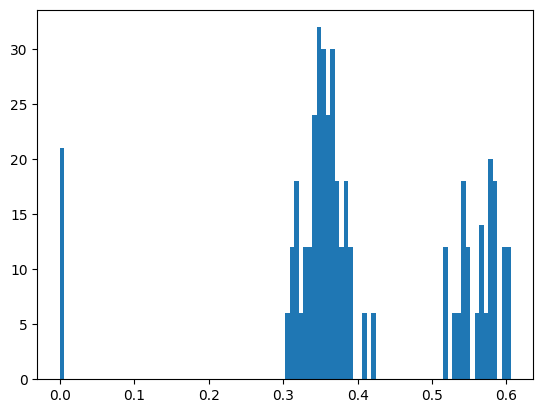

In [6]:
import matplotlib.pyplot as plt
distances = []
for i, ci in enumerate(carbons):
    vectors = []
    for cj in carbons:
        d = ci - cj
        # PBC
        d -= np.floor(d + 0.5)
        # fractional to absolute
        d = d @ cell
        distances.append(np.linalg.norm(d))

H = plt.hist(distances, bins=100)

## Methane AのBOOを計算する

In [10]:
import boo

neighbors = dict()

numAtoms = carbons.shape[0]

boos = np.zeros([carbons.shape[0], 5])
rc = 0.45

for i, ci in enumerate(carbons):
    vectors = []
    for cj in carbons:
        d = ci - cj
        # PBC
        d -= np.floor(d + 0.5)
        # fractional to absolute
        d = d @ cell
        if 0 < d @ d < rc**2:
            vectors.append(d)

    vectors = np.array(vectors)
    print(np.min(np.linalg.norm(vectors, axis=1)))
    print(len(vectors))
    for k, l in enumerate([4, 6, 8, 10, 12]):
        X = vectors[:, 0]
        Y = vectors[:, 1]
        Z = vectors[:, 2]
        booo = boo.boo(l, X, Y, Z)
        print(f"boo Q_{l} {booo}")
        boos[i, k] = booo


0.3278778629487718
12
boo Q_4 (0.052075119792321+0j)
boo Q_6 (0.6560926934672583+0j)
boo Q_8 (0.08534180303113023+0j)
boo Q_10 (0.3661634414200464+0j)
boo Q_12 (0.5649766662840319+0j)
0.31997173451417105
13
boo Q_4 (0.1190761106574624+0j)
boo Q_6 (0.4405074956196337+0j)
boo Q_8 (0.2791722644387966+0j)
boo Q_10 (0.19656099452687184+0j)
boo Q_12 (0.34815215210861755+0j)
0.3042920896517887
13
boo Q_4 (0.09523456040630233+0j)
boo Q_6 (0.42572957058005567+0j)
boo Q_8 (0.2946639209095008+0j)
boo Q_10 (0.19088303079375807+0j)
boo Q_12 (0.35805047848361504+0j)
0.3099680002675364
13
boo Q_4 (0.057653653020221664+0j)
boo Q_6 (0.46071163192689285+0j)
boo Q_8 (0.11050220016776373+0j)
boo Q_10 (0.2393878275708224+0j)
boo Q_12 (0.30763292002131604+0j)
0.31275131296610126
13
boo Q_4 (0.05905851838986556+0j)
boo Q_6 (0.5103578734452086+0j)
boo Q_8 (0.17348652077260818+0j)
boo Q_10 (0.267624821234475+0j)
boo Q_12 (0.34441208777623283+0j)
0.3260884207596315
14
boo Q_4 (0.06659194086310229+0j)
boo Q_6 (0

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_22068/162812985.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  boos[i, k] = booo


In [11]:
# 扱いやすいように、見出しをつけてpandasデータフレームにする。
import pandas as pd

df_MeA = pd.DataFrame(boos, columns=["q_4", "q_6", "q_8", "q_10", "q_12"])
df_MeA

,q_4,q_6,q_8,q_10,q_12
0,0.052075,0.656093,0.085342,0.366163,0.564977
1,0.119076,0.440507,0.279172,0.196561,0.348152
2,0.095235,0.425730,0.294664,0.190883,0.358050
3,0.057654,0.460712,0.110502,0.239388,0.307633
4,0.059059,0.510358,0.173487,0.267625,0.344412
5,0.066592,0.382073,0.175563,0.129742,0.308134
6,0.055243,0.388227,0.163406,0.172440,0.293773
7,0.091270,0.439307,0.282083,0.192860,0.276011
8,0.066793,0.465259,0.286547,0.235427,0.298136
9,0.057654,0.460712,0.110502,0.239388,0.307633


ペアプロットを作る。

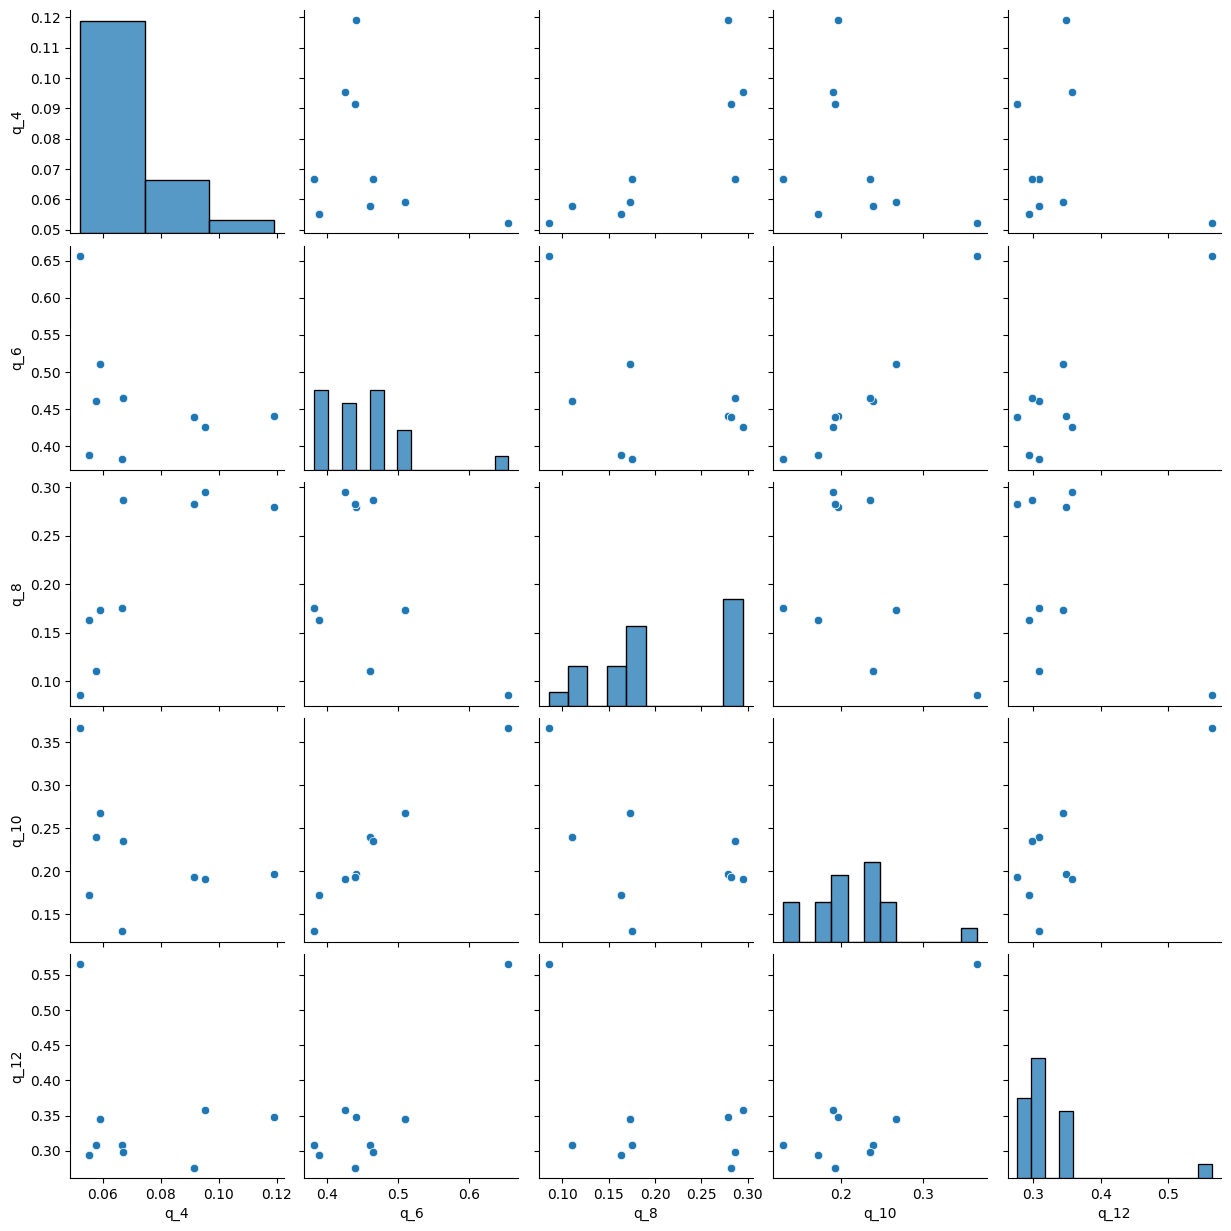

In [12]:
import seaborn as sns

sns.pairplot(df_MeA, diag_kws=dict(bins=100, binwidth=0.02))

これと比較すると、300 K/60000 barはMethane Aと言える。

Methane A構造のQ4〜Q12の5次元の散布を、5次元のガウス関数で近似し、その共分散行列を作る。(本当は、熱揺らぎで分布がひろがった状態で計算したほうがいい)

In [61]:
import numpy as np
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=1, random_state=0).fit(boos)
gm.means_, gm.covariances_

(array([[0.06934371, 0.45048262, 0.20161619, 0.2126691 , 0.32168941]]),
 array([[[ 0.00029863, -0.00021637,  0.00089581, -0.0002733 ,
          -0.00017541],
         [-0.00021637,  0.00384639, -0.00101346,  0.00329318,
           0.00290437],
         [ 0.00089581, -0.00101346,  0.00490349, -0.00099787,
          -0.00160458],
         [-0.0002733 ,  0.00329318, -0.00099787,  0.00303498,
           0.00221868],
         [-0.00017541,  0.00290437, -0.00160458,  0.00221868,
           0.00353271]]]))